# Adversarial attack

To explore the vulnerabilities of Convolutional Neural Networks (CNNs) to adversarial attacks, I'll be developing custom attack strategies within this notebook to deceive a deep neural network. Let's start by importing the necessary libraries:

In [1]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

<ipython-input-1-1e6e32f09a96>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


In [2]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

Unzipping file...
Unzipping file...


## Deep CNNs on ImageNet


In this notebook, I'll utilize standard CNN architectures pre-trained on the ImageNet dataset, conveniently available through PyTorch's torchvision package. For our experiments on Google Colab, I'll opt for the resnext50_32x4d architecture.

In [3]:
import torchvision.models as models

In [4]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH

# Load ResNet-50 with pre-trained weights
pretrained_model = models.resnext50_32x4d(pretrained=True)
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to ../saved_models/tutorial10/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 85.6MB/s]


To conduct adversarial attacks, a dataset is necessary. Since the CNN model has been trained on ImageNet, it's appropriate to conduct the attacks using data from the ImageNet dataset.

In [5]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Before initiating the attack, it's crucial to verify the model's performance. In ImageNet, with its 1000 classes, simply assessing accuracy isn't sufficient. Consider a scenario where a model consistently predicts the true label as the second-highest class in its softmax output. Although it may appear to recognize the object, it would achieve an accuracy of 0. In ImageNet, where each image can belong to multiple classes, there isn't always a single clear label assigned to an image. Therefore, for image classifications across numerous classes, a common alternative metric is "Top-5 accuracy," indicating how often the true label appears within the 5 most likely predictions of the model. Since models typically perform well in this regard, I prefer reporting the error (1 - accuracy) instead of the accuracy itself:

In [6]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [7]:
_ = eval_model(data_loader)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 10.16%
Top-5 error: 1.20%



The resnext50_32x4d achieves a respectable error rate of 1.20% for the top-5 predictions. Now, I can examine some predictions of the model to become more familiar with the dataset. The function below plots an image alongside a bar diagram of its predictions.

In [8]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    print(topk_vals)
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

Let's visualize a few images below:

[9.9724990e-01 6.6637853e-04 3.0899089e-04 2.8180855e-04 2.7216232e-04]


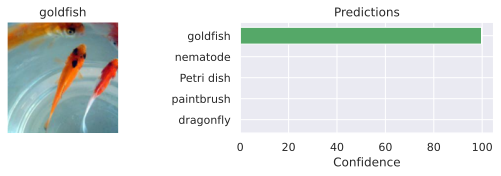

[8.236273e-01 9.249510e-02 8.245378e-02 2.183233e-04 1.428944e-04]


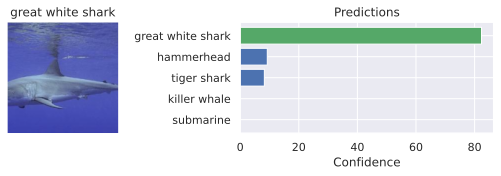

[9.9354529e-01 3.2530974e-03 2.1448901e-03 2.9317912e-04 2.5326369e-04]


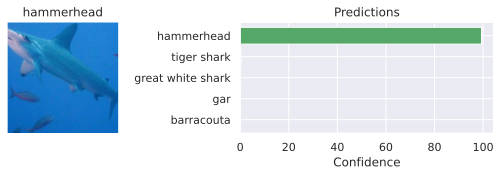

[0.96777934 0.00920232 0.00412077 0.00311807 0.00290294]


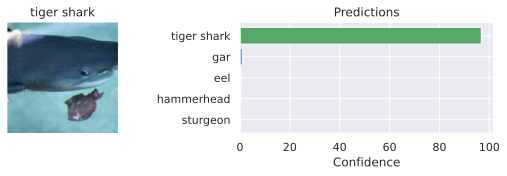

In [9]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in [9,12,23,18]:      #(1,32,8) (3,6,13,18)
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

The bar plot on the right shows the top-5 predictions of the model with their class probabilities. We denote the class probabilities with "confidence" as it somewhat resembles how confident the network is that the image is of one specific class. Some of the images have a highly peaked probability distribution, and we would expect the model to be rather robust against noise for those. However, we will see below that this is not always the case. Note that all of the images are of fish because the data loader doesn't shuffle the dataset. Otherwise, we would get different images every time we run the notebook, which would make it hard to discuss the results on the static version.



### Fast Gradient Sign Method (FGSM)

One of the first attack strategies proposed is Fast Gradient Sign Method (FGSM), developed by [Ian Goodfellow et al.](https://arxiv.org/pdf/1412.6572.pdf) in 2014. Given an image, I create an adversarial example by the following expression:

$$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_x J(\theta,x,y))$$

The term $J(\theta,x,y)$ represents the loss of the network for classifying input image $x$ as label $y$; $\epsilon$ is the intensity of the noise, and $\tilde{x}$ the final adversarial example. The equation resembles SGD and is actually nothing else than that. We change the input image $x$ in the direction of *maximizing* the loss $J(\theta,x,y)$. This is exactly the other way round as during training, where we try to minimize the loss. The sign function and $\epsilon$ can be seen as gradient clipping and learning rate specifically. We only allow our attack to change each pixel value by $\epsilon$. You can also see that the attack can be performed very fast, as it only requires a single forward and backward pass. Let's implement it below:

In [10]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.02):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

The default value of $\epsilon=0.02$ corresponds to changing a pixel value by about 1 in the range of 0 to 255, e.g. changing 127 to 128. This difference is marginal and can often not be recognized by humans. Let's try it below on our example images:

[0.5270843  0.12523112 0.05286976 0.0464281  0.04132225]


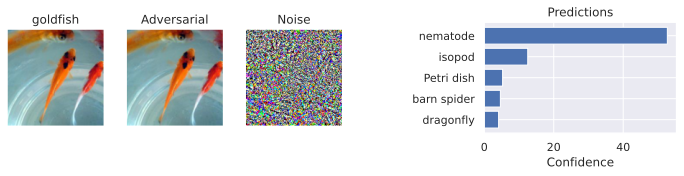

[9.7344685e-01 1.5117136e-02 8.5769743e-03 4.6782539e-04 2.0903825e-04]


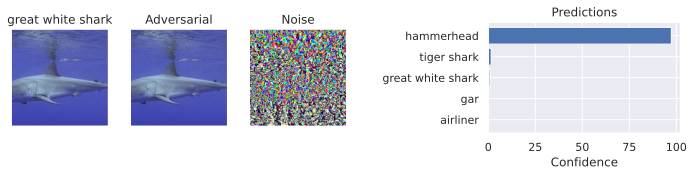

[0.49819088 0.05897242 0.0587891  0.05363726 0.0401329 ]


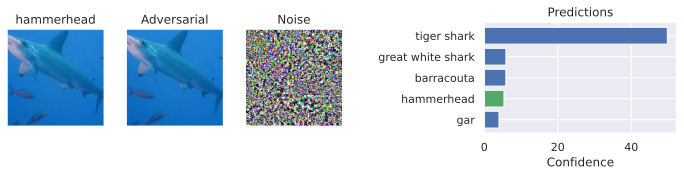

[0.3438277  0.12223125 0.08766544 0.07480688 0.0241882 ]


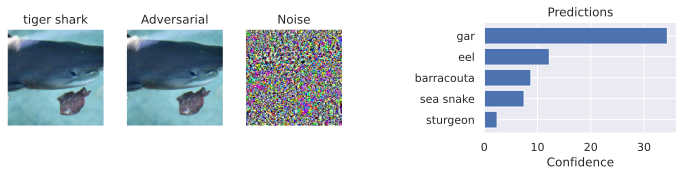

In [11]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.01)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))

for i in [9,12,23,18]:   #(1,32,8)
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

[0.30994576 0.14479548 0.1130109  0.10856663 0.0773056 ]


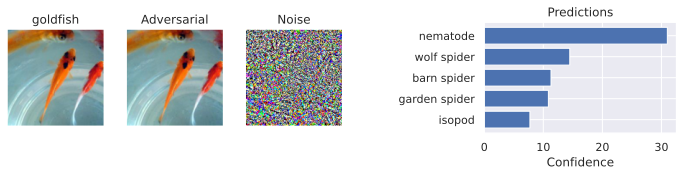

[9.8666650e-01 6.6196560e-03 4.6383259e-03 5.4500095e-04 1.2614192e-04]


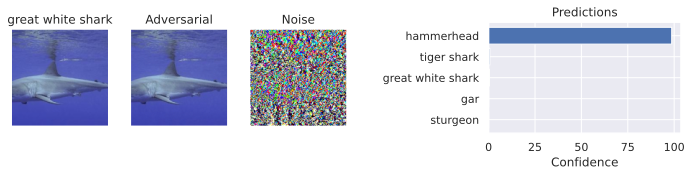

[0.45919856 0.06866587 0.06704964 0.04008072 0.03745502]


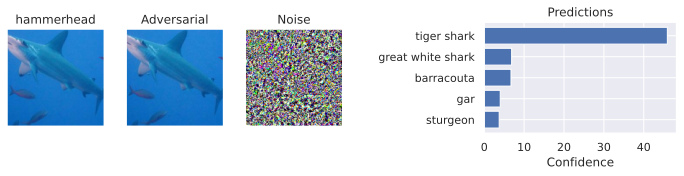

[0.28537214 0.15960701 0.06398632 0.05913747 0.02586792]


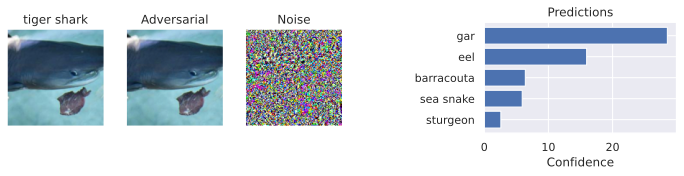

In [12]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.02)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))

for i in [9,12,23,18]:   #(1,32,8)
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

[0.5440782  0.18956725 0.05135142 0.0331817  0.03123191]


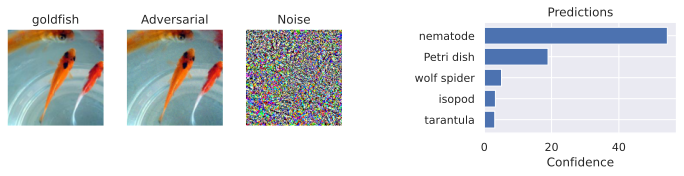

[9.8622352e-01 5.7645845e-03 5.2708653e-03 1.4850565e-03 2.6039488e-04]


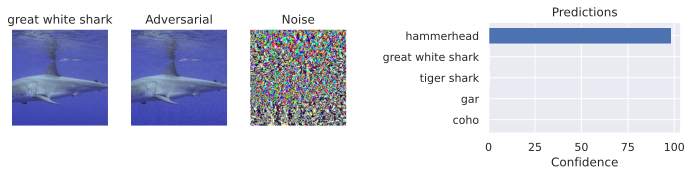

[0.3307449  0.15009463 0.12243258 0.08155668 0.06760747]


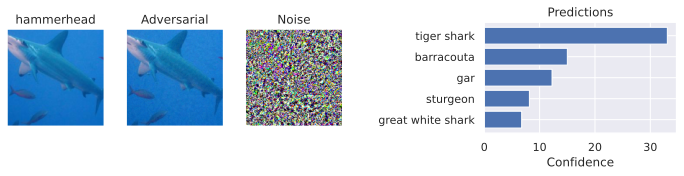

[0.19919461 0.11389489 0.07567172 0.0299369  0.02356418]


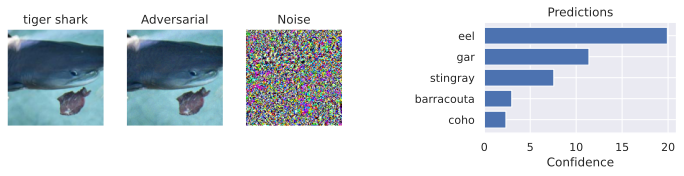

In [13]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.08)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))

for i in [9,12,23,18]:   #(1,32,8)
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

[0.5543302  0.24974377 0.03664743 0.02606684 0.02339448]


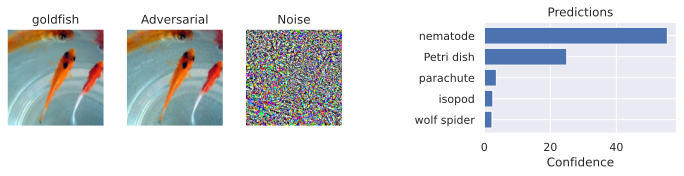

[9.8418623e-01 7.8782057e-03 5.1591503e-03 1.5557657e-03 2.1766158e-04]


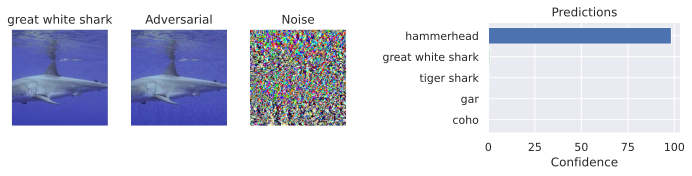

[0.32783023 0.16566953 0.15105674 0.08910602 0.08600611]


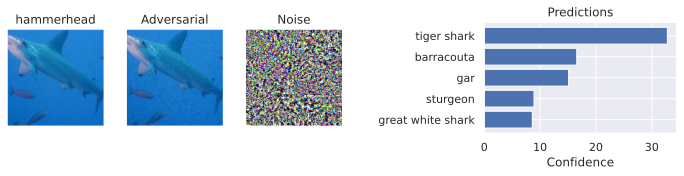

[0.17484124 0.16254295 0.07279329 0.03690895 0.02511606]


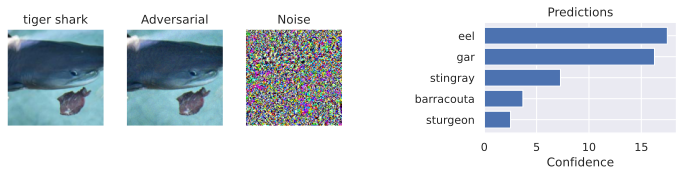

In [14]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.10)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))

for i in [9,12,23,18]:   #(1,32,8)
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

Despite the minor amount of noise, we are able to fool the network on all of our examples. None of the labels have made it into the top-5, showing that we indeed fooled the model. We can also check the accuracy of the model on the adversarial images:

In [25]:
import pandas as pd

# Define the list of epsilon values
epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

# Initialize lists to store results
top1_errors = []
top5_errors = []

# Evaluate the model for each epsilon value and store the results
for epsilon in epsilons:
    result = eval_model(data_loader, img_func=lambda x, y: fast_gradient_sign_method(pretrained_model, x, y, epsilon=epsilon)[0])
    top1_errors.append(100*(1-result[0]))
    top5_errors.append(100*(1-result[1]))

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 77.88%
Top-5 error: 33.82%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 87.62%
Top-5 error: 49.58%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 90.34%
Top-5 error: 55.62%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 91.38%
Top-5 error: 59.14%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 91.80%
Top-5 error: 60.58%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 91.64%
Top-5 error: 61.36%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 91.34%
Top-5 error: 61.66%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 91.16%
Top-5 error: 61.60%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 90.96%
Top-5 error: 61.58%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 90.74%
Top-5 error: 61.16%


In [26]:
# Create DataFrame
df = pd.DataFrame({
    'Epsilon': epsilons,
    'Top-1 Error': top1_errors,
    'Top-5 Error': top5_errors
})

# Print DataFrame
print(' Performance of DenseNet161 under FGSM attack for different values of ε ')
print('_______________________________________________________________________')
print('                                                                                    ')
print(df)

 Performance of DenseNet161 under FGSM attack for different values of ε 
_______________________________________________________________________
                                                                                    
   Epsilon  Top-1 Error  Top-5 Error
0     0.01        77.88        33.82
1     0.02        87.62        49.58
2     0.03        90.34        55.62
3     0.04        91.38        59.14
4     0.05        91.80        60.58
5     0.06        91.64        61.36
6     0.07        91.34        61.66
7     0.08        91.16        61.60
8     0.09        90.96        61.58
9     0.10        90.74        61.16


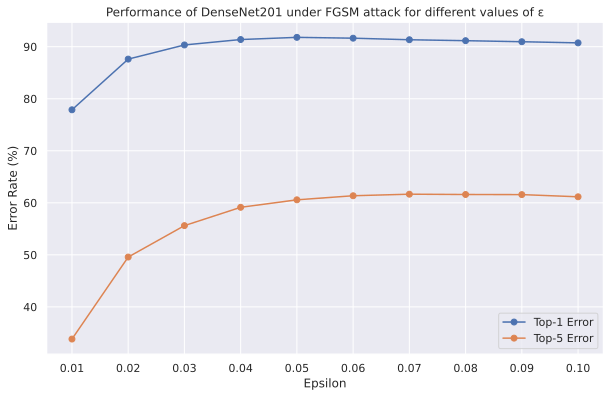

In [27]:
# Plot
plt.figure(figsize=(10, 6))

plt.plot(df['Epsilon'], df['Top-1 Error'], marker='o', label='Top-1 Error')
plt.plot(df['Epsilon'], df['Top-5 Error'], marker='o', label='Top-5 Error')

# Add labels and title
plt.title(' Performance of DenseNet201 under FGSM attack for different values of ε ')
plt.xlabel('Epsilon')
plt.ylabel('Error Rate (%)')
plt.xticks(df['Epsilon'])
plt.grid(True)
plt.legend()

# Show plot
plt.show()

# ***Results:***

Prior to the FGSM attack, the baseline accuracy of the resnext50_32x4d model was established, with a Top-1 error of 10.16% and a Top-5 error of 1.20%.

Following the FGSM attack, successful exploitation was observed, resulting in a reduction in accuracy, indicated by an increase in classification error as the epsilon values for the FGSM attack were incremented from 0.01 to 0.1.

The impact of the FGSM attack was significant, with classification errors for the resnext50_32x4d model under attack reaching as high as 90.74% (Top-1 error) and 61.16% (Top-5 error).